<img src="../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Brain Observatory - Visual Behavior </h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain </h2> 
<h3 align="center">Monday, August 26, 2018</h3> 

<img src="../resources/visual_behavior_experiment.png" height="400" width="1200">  


This notebook will introduce you to the Visual Behavior Brain Observatory dataset. This dataset uses 2-photon calcium imaging (also called optical physiology or ophys) to measure neural activity in mice performing a visual change detection task. One aim of this dataset is to ask: how is sensory coding influenced by expectation, engagement, and experience?

The change detection task consists of a series of image presentations. Each image flash is 250ms followed by 500ms of gray screen. The task for the mouse is to lick in a 750ms response window following a change in image identity. On each trial, a change time is scheduled. On go trials, a change in image identity occurs. On catch trials, no image change occurs (aka 'sham change'), and we measure false alarm rates in the same 750ms response window. Correct responses are rewarded and licks outside the response window result in a timeout.

There are 8 natural scene images shown in each behavioral session. Mice learn the task with one set of 8 natural scenes which become highly familiar with experience. During the imaging phase of the experiment, mice perform the task with the familiar image set, as well as another set of 8 images that are experienced for the first time under the microscope. This allows us to ask how training history and visual experience infuence sensory responses. 

There are 2 types of sessions during the imaging portion of the experiment - active behavior and passive viewing. During the passive viewing sessions, the task is run in open loop mode with the lick spout retracted, after the mouse has been give its daily allocation of water. This allows us to ask how representations differ when the mouse is actively engaged in the task and motivated to earn water rewards compared to when it is sated and not receiving reward feedback.

During imaging sessions, 5% of non-change image flashes are randomly omitted from the otherwise regular sequence of stimulus presentations. This allows us to ask whether expectation signals are present in the visual cortex. 

The dataset consists of recordings from excitatory (Slc17a7-IRES2-Cre;CaMK2-tTA;Ai93(GCaMP6f)) and VIP inhibitory (VIP-IRES-Cre;Ai162(GCaMP6f)) neurons in V1. Excitatory cells were sampled at 2 depths: 175um (L2/3) and 375um (L5). VIP cells were sampled at 175um depth.

In this notebook, we will describe the core components of each experimental session and the tools for accessing and analyzing the data.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p>Let's get started

</div>

In [1]:
# you will need these libraries for computation & data manipulation
import os
import numpy as np
import pandas as pd

# matplotlib is a standard python visualization package
import matplotlib.pyplot as plt
%matplotlib inline

# seaborn is another library for statistical data visualization
# seaborn style & context settings make plots pretty & legible
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})
sns.set_style('white')
sns.set_palette('deep');

# Import allensdk modules for loading and interacting with the data
from allensdk.brain_observatory.behavior.swdb import behavior_project_cache as bpc


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>The first thing we will do is use the `allensdk` to load a cache for the visual behavior dataset, which contains a manifest describing the dimensions of the dataset and methods for loading the data from particular sessions. You can inspect the manifest contained in the cache to identify experiments of interest and their metadata. 

<p>Make sure you have access to the `visual_behavior_cache.json` file, which tells the cache object where to find the data. </div>

In [2]:
# AWS paths

# Mac/Linux paths
# cache_json = {'manifest_path': '/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/SWDB_2019/visual_behavior_data_manifest.csv',
#               'nwb_base_dir': '/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/SWDB_2019/nwb_files',
#               'analysis_files_base_dir': '/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/SWDB_2019/analysis_files',
#               'analysis_files_metadata_path': '/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/SWDB_2019/analysis_files_metadata.json'
# }
# Windows paths
cache_json = {'manifest_path': r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\SWDB_2019\visual_behavior_data_manifest.csv',
              'nwb_base_dir': r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\SWDB_2019\nwb_files',
              'analysis_files_base_dir': r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\SWDB_2019\analysis_files',
              'analysis_files_metadata_path': r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\SWDB_2019\analysis_files_metadata.json'
             }

cache = bpc.BehaviorProjectCache(cache_json)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 1.1:**  Get information about what's in the dataset 

<p>Read in 'visual_behavior_data_manifest.csv' using the cache object and explore the columns to see the available visual areas, cre lines, and session types. 

</div>

In [3]:
# get the manifest of all experiment sessions for this dataset
manifest = cache.manifest
manifest.head(10)

,ophys_experiment_id,container_id,full_genotype,imaging_depth,targeted_structure,stage_name,animal_name,sex,date_of_acquisition,retake_number
0,792815735,791352433,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,175,VISp,OPHYS_1_images_A,744911447,F,2018-12-10 21:19:50,0.0
1,798404219,791352433,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,175,VISp,OPHYS_2_images_A_passive,744911447,F,2018-12-18 23:26:29,1.0
2,795073741,791352433,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,175,VISp,OPHYS_3_images_A,744911447,F,2018-12-13 21:11:17,0.0
3,795953296,791352433,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,175,VISp,OPHYS_4_images_B,744911447,F,2018-12-14 20:17:05,0.0
4,796108483,791352433,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,175,VISp,OPHYS_5_images_B_passive,744911447,F,2018-12-15 20:56:37,0.0
5,796308505,791352433,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,175,VISp,OPHYS_6_images_B,744911447,F,2018-12-16 20:44:48,0.0
6,806456687,803517529,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,375,VISp,OPHYS_1_images_A,772629800,M,2019-01-09 18:20:00,0.0
7,811456530,803517529,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,375,VISp,OPHYS_2_images_A_passive,772629800,M,2019-01-21 19:02:47,2.0
8,807752719,803517529,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,375,VISp,OPHYS_3_images_A,772629800,M,2019-01-11 18:12:55,0.0
9,808619543,803517529,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,375,VISp,OPHYS_4_images_B,772629800,M,2019-01-14 17:59:54,0.0


In [4]:
# what are the dimensions of this dataset? 
print('targeted structures:', manifest.targeted_structure.unique())
print('\ncre_lines:', manifest.full_genotype.unique())
print('\nstage_types:', manifest.stage_name.unique())

targeted structures: ['VISp']

cre_lines: ['Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt'
 'Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt']

stage_types: ['OPHYS_1_images_A' 'OPHYS_2_images_A_passive' 'OPHYS_3_images_A'
 'OPHYS_4_images_B' 'OPHYS_5_images_B_passive' 'OPHYS_6_images_B']


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 1.2:**  Everyone gets an experiment! 

<p>Get your experiment ID and assign it to a variable called `experiment_id`

<p>What is the `targeted_structure`, 'imaging_dpeth', `full_genotype`, and `stage_name` for your `experiment_id`? 

</div>

In [5]:
# get a random experiment
experiment_index = np.random.random_integers(low=0,high=len(manifest.ophys_experiment_id.values))
experiment_id = manifest.ophys_experiment_id.values[experiment_index]

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 80 + 1) instead
  


In [6]:
# get the metadata for this experiment from the manifest
row = manifest.loc[manifest['ophys_experiment_id'] == experiment_id]
print(row.targeted_structure.values)
print(row.imaging_depth.values)
print(row.full_genotype.values)
print(row.stage_name.values)

['VISp']
[375]
['Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt']
['OPHYS_2_images_A_passive']


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 1.3:**  What is in an experiment container? 

<p>The experiment container describes a set of imaging sessions performed at the same location (targeted structure and imaging depth) in the same mouse that targets the same set of cells. All the sessions in an experiment container have a common `experiment_container_id`.

<p>Get a the `experiment_container_id` for your `experiment_id` and find out what other sessions were recorded at that same location.

<p>Do all experiment containers have the same number of sessions associated with them? 
</div>

In [7]:
# get the container ID for this experiment
container_id = manifest[manifest.ophys_experiment_id==experiment_id]['container_id'].values[0]

In [8]:
# what other sessions are in this container?
manifest.groupby('container_id').get_group(container_id)

,ophys_experiment_id,container_id,full_genotype,imaging_depth,targeted_structure,stage_name,animal_name,sex,date_of_acquisition,retake_number
50,848697604,845588020,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,375,VISp,OPHYS_1_images_A,820871399,M,2019-04-09 16:16:45,0.0
51,849203586,845588020,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,375,VISp,OPHYS_2_images_A_passive,820871399,M,2019-04-10 15:55:28,0.0
52,864370674,845588020,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,375,VISp,OPHYS_3_images_A,820871399,M,2019-05-07 17:27:47,4.0
53,862848066,845588020,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,375,VISp,OPHYS_4_images_B,820871399,M,2019-05-01 17:05:37,2.0
54,855582981,845588020,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,375,VISp,OPHYS_5_images_B_passive,820871399,M,2019-04-22 19:33:25,1.0
55,856096766,845588020,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,375,VISp,OPHYS_6_images_B,820871399,M,2019-04-23 16:57:21,1.0


In [9]:
# Get number of sessions in each container
manifest.groupby('container_id').size()

container_id
791352433    6
803517529    5
803589437    6
812858755    5
814796612    6
814797528    5
825183217    6
829561794    6
843049827    5
845588020    6
846213087    6
846215539    6
848390542    6
869781307    6
dtype: int64

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>The Behavior OPhys Session object</h2>
<p>The BehaviorOphysSession class in allensdk.brain_observatory.behavior.behavior_ophys_session provides an interface to all of the data for a single experimental session from the Visual Behavior pipeline, aligned to a common time clock.

<p>We package each session's data into a Neurodata Without Borders 2.0 (NWB) file. The BehaviorOphysSession will load data from the NWB file for a given session.
    
<p>You can load a BehaviorOphysSession object easily using the 'get_session' method of the cache object. 

<p>Use help to see what functions are contained in the session object. 


</div>

In [10]:
# get a session from the cache
session = cache.get_session(experiment_id)

In [11]:
help(session)

Help on ExtendedBehaviorSession in module allensdk.brain_observatory.behavior.swdb.behavior_project_cache object:

class ExtendedBehaviorSession(allensdk.brain_observatory.behavior.behavior_ophys_session.BehaviorOphysSession)
 |  ExtendedBehaviorSession(api)
 |  
 |  Represents data from a single Visual Behavior Ophys imaging session.  LazyProperty attributes access the data only on the first demand, and then memoize the result for reuse.
 |  
 |  Attributes:
 |      ophys_experiment_id : int (LazyProperty)
 |          Unique identifier for this experimental session
 |      max_projection : allensdk.brain_observatory.behavior.image_api.Image (LazyProperty)
 |          2D max projection image
 |      stimulus_timestamps : numpy.ndarray (LazyProperty)
 |          Timestamps associated the stimulus presentations on the monitor 
 |      ophys_timestamps : numpy.ndarray (LazyProperty)
 |          Timestamps associated with frames captured by the microscope
 |      metadata : dict (LazyPrope

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 2.1:**  What is an experiment session? 

<p>Use tab completion to see what is in the dataset object for an experiment session

<p>What is in the `metadata` attribute? What is in the 'task_parameters' attribute?

</div>


In [12]:
# get session metadata
session.metadata

{'age': 'P137',
 'ophys_frame_rate': 31.0,
 'experiment_container_id': 845588020,
 'stimulus_frame_rate': 60.0,
 'targeted_structure': 'VISp',
 'sex': 'M',
 'reporter_line': ['Ai93(TITL-GCaMP6f)'],
 'field_of_view_width': 452,
 'emission_lambda': 520.0,
 'full_genotype': 'Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt',
 'imaging_depth': 375,
 'driver_line': ['Camk2a-tTA', 'Slc17a7-IRES2-Cre'],
 'LabTracks_ID': 445270,
 'ophys_experiment_id': 849203586,
 'rig_name': 'CAM2P.3',
 'behavior_session_uuid': UUID('79815f0b-08bd-48f5-8fca-971bf802ab65'),
 'session_type': 'Unknown',
 'excitation_lambda': 910.0,
 'indicator': 'GCAMP6f',
 'field_of_view_height': 512,
 'experiment_datetime': datetime.datetime(2019, 4, 10, 8, 55, 28, tzinfo=tzutc())}

In [13]:
# get session task parameters
session.task_parameters

{'reward_volume': 0.007,
 'response_window_sec': [0.15, 0.75],
 'stage': 'OPHYS_2_images_A_passive',
 'stimulus_distribution': 'geometric',
 'stimulus': 'images',
 'blank_duration_sec': [0.5, 0.5],
 'stimulus_duration_sec': 0.25,
 'omitted_flash_fraction': 0.05,
 'task': 'DoC_untranslated',
 'n_stimulus_frames': 69179}

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Optical physiology data - max projection, roi masks, and fluorescence traces</h2>

<p>Let's use the session object to access neuron fluorescence timeseries, roi masks, and metadata. An ROI mask is used to define the boundary of each cell in the flourescence data. The timeseries extracted from each ROI is one cell's activity.

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 2.1: max intensity projection and ROI masks** 
    
<p>Get the maximum intensity projection image using the `max_projection` attribute for your dataset and display it. 
    
<p>Get the 'segmentation_mask_image' and display it next to the max projection. 
</div>

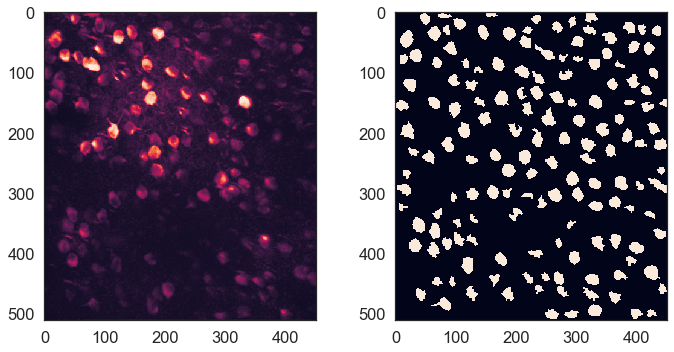

In [14]:
# plot the max intensity projection and the segmentation mask
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
ax[0].imshow(session.max_projection)
ax[1].imshow(session.segmentation_mask_image)
plt.tight_layout()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 2.2: Get dF/F traces and ophys timestamps**

<p>Get the fluorescence traces and ophys timestamps. How are they formatted?

<p>`dff_traces` is a dataframe with 'cell_specimen_id' as the index and 'cell_roi_id' and 'dff' as columns. 
    
<p>'cell_roi_id' is the unique identifier for each cell within a session. 'cell_specimen_id' is the unified cell identifier after cells are matched across sessions within a container. Cells found in multiple sessions will have the same 'cell_specimen_id' in all the sessions in which they were found.  
    
<p>the 'dff' column contains the baseline normalized fluorescence traces, also called dF/F traces, for each cell in the session. 
    
<p>`timestamps_ophys` is an array of timestamps for each 2P imaging frame. 
    
<p>Check that the length of one of the dF/F traces is the same length as the ophys timestamps.

</div>

In [15]:
# get traces and timestamps
dff_traces = session.dff_traces
timestamps_ophys = session.ophys_timestamps

In [16]:
dff_traces.head()

,dff
cell_specimen_id,
915115528,"[0.1496761072238361, 0.29303911440474384, 0.31..."
915116952,"[0.06431609739098537, 0.15901018175273704, 0.3..."
915113524,"[0.02846148222339146, 0.036980625453035654, 0...."
915104047,"[0.10120641033360739, 0.003348731284224356, 0...."
915113226,"[0.05818066529290636, 0.0878151569712262, 0.02..."


In [17]:
# get shape of traces and timestamps
print('shape of dff_traces:',dff_traces.shape)
print('shape of timestamps_ophys:',timestamps_ophys.shape)

shape of dff_traces: (164, 1)
shape of timestamps_ophys: (139920,)


In [18]:
# you can also skip the step of assigning the attribute to a variable and use the datasest attribute directly
print('shape of dff_traces:',session.dff_traces.shape)
print('shape of timestamps_ophys:',session.ophys_timestamps.shape)

shape of dff_traces: (164, 1)
shape of timestamps_ophys: (139920,)


In [19]:
# shape of one cell's trace
print('shape of one trace:',dff_traces.iloc[0]['dff'].shape)

shape of one trace: (139920,)


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 2.3: Plot the dF/F trace for a cell**

<p>Plot the dF/F trace for one cell by indexing into the `dff_traces` array. Use `timestamps_ophys` to plot the y_axis in seconds. 
    
<p>Try plotting the trace for a few different cells.

</div>

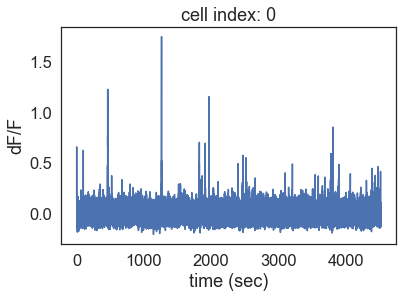

In [20]:
# plot the dF/F trace for one cell using ophys timestamps for x-axis values
# indexing method using row index with .iloc
cell_index = 0 
dff_trace = dff_traces.iloc[cell_index]['dff'] # note that the column name is outside of the .iloc call
plt.plot(timestamps_ophys, dff_trace)
plt.xlabel('time (sec)');
plt.ylabel('dF/F');
plt.title('cell index: '+str(cell_index));

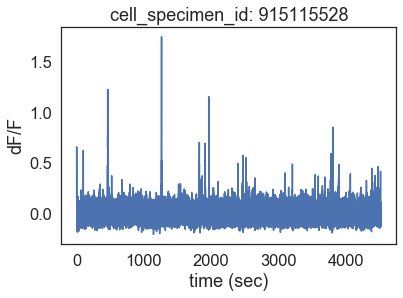

In [21]:
# plot the dF/F trace for one cell using ophys timestamps for x-axis values
# indexing method using cell_specimen_id as index with .loc

# get cell_specimen_id from a list of all cell_specimen_ids
cell_specimen_ids = dff_traces.index.values
cell_specimen_id = cell_specimen_ids[cell_index]

#another way to get the cell_specimen_id using a row index (aka integer # of the row)
cell_specimen_id = dff_traces.iloc[cell_index].name # The df is indexed by the specimen id. Use the row.name attr to get the index

dff_trace = dff_traces.loc[cell_specimen_id, 'dff'] #note how the column name is included in the .loc call
plt.plot(timestamps_ophys, dff_trace)
plt.xlabel('time (sec)');
plt.ylabel('dF/F');
plt.title('cell_specimen_id: '+str(cell_specimen_id));

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 2.4: Plot a heatmap of all cell traces in this session**

<p>Extract the dff_traces from the dataframe into an array. What is the shape?

<p>Use the matplotlib plotting function pcolormesh to plot the matrix as a heatmap. 

</div>

In [22]:
# turn dff_traces into an array of cells x timepoints
dff_traces_array = np.vstack(dff_traces.dff.values)
print('shape of dff_traces_array:',dff_traces_array.shape)

shape of dff_traces_array: (164, 139920)


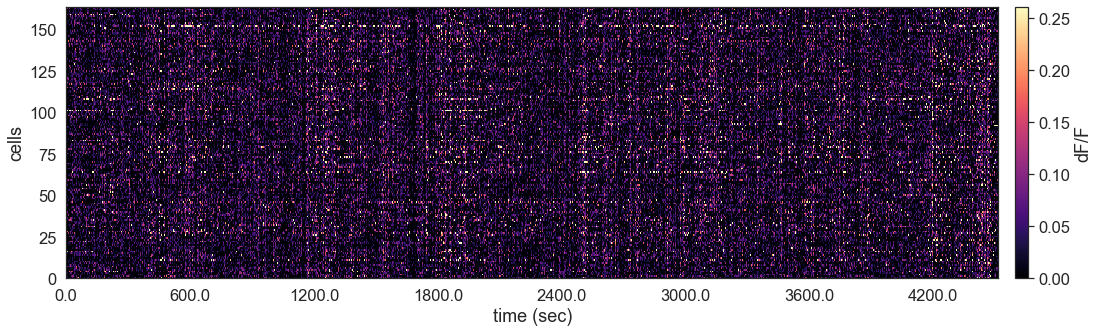

In [23]:
# plot a heatmap of all traces 
fig, ax = plt.subplots(figsize=(20,5))
cax = ax.pcolormesh(dff_traces_array, cmap='magma', vmin=0, vmax=np.percentile(dff_traces_array, 99))
ax.set_yticks(np.arange(0, len(dff_traces_array)), 10);
ax.set_ylabel('cells')
ax.set_xlabel('time (sec)')
ax.set_xticks(np.arange(0, len(timestamps_ophys), 600*31));
ax.set_xticklabels(np.arange(0, timestamps_ophys[-1], 600));
cb = plt.colorbar(cax, pad=0.015, label='dF/F')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Behavior timeseries and events - running, licks, and rewards </h2>
<p>As the mouse performs the behavioral task, it is free to run on a disk. The task is a go/no-go style task with licking as the behavioral response. When a mouse correctly licks the water spout, a reward is delivered. 

<p>Running, licks and rewards are measured at the stimulus frame display rate and share timestamps with the stimulus. </div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 3.1: Get running speed trace and timestamps** 

<p>Get the `running_speed` attribute of the dataset object. What does it contain? 

<p>Runnning speed shares timestamps with the visual stimulus. Compare the values of running timestamps from  `running_speed` with the values in the dataset attribute `stimulus_timestamps`. 
</div>

In [24]:
# get running speed
session.running_speed

RunningSpeed(timestamps=array([   5.63371,    5.65035,    5.66713, ..., 4508.04018, 4508.05685,
       4508.07352]), values=array([ 0.        ,  0.66183894,  0.00157393, ..., -0.26800762,
        0.        ,  0.        ]))

In [25]:
# what are the values of running speed timestamps?
print('running speed timestamps:',session.running_speed.timestamps)

running speed timestamps: [   5.63371    5.65035    5.66713 ... 4508.04018 4508.05685 4508.07352]


In [26]:
# what are the values of stimulus timestamps?
print('stimulus timestamps:',session.stimulus_timestamps)

stimulus timestamps: [   5.63371    5.65035    5.66713 ... 4508.04018 4508.05685 4508.07352]


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 3.2: Plot running speed**

<p>Plot the values for running speed with time in seconds on the x-axis. 
    
<p>Running speed is measured in cm/s. Label the axes appropriately.
        
</div>

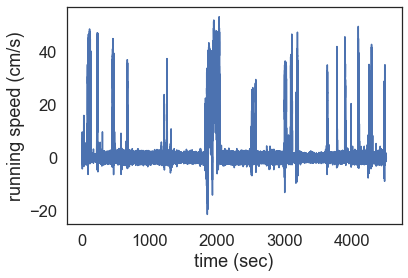

In [27]:
# plot running speed with timestamps on x-axis
plt.plot(session.running_speed.timestamps, session.running_speed.values)
plt.ylabel('running speed (cm/s)');
plt.xlabel('time (sec)');

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 3.4: Rewards and licks**
    
<p>Get the 'rewards' attribute of the session object. How is it formatted? 

<p>Get the 'licks' attribute of the session object. How is it formatted? 

<p>What is the relationship between running, licking and rewards? 
</div>

In [37]:
# Get information about rewards
session.rewards.head()

,timestamps,volume,autorewarded


In [29]:
# Get information about licks
session.licks.head()

,timestamps


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 3.5: Plot licking, reward times, and running trace on the same figure**
    
<p>1) Plot `running_speed` as above, but set xlims to focus on a 30 second portion of the behavior session, from x=600 to x=630. 

<p>2) Plot `rewards` as points (not a line), at y = -10. Note that `rewards` is a dataframe, with timestamps as the index. Use the values of the index to get the times of all rewards to plot along the x-axis.

<p>Hint: You will need to create an array of len(session.rewards.index.values) filled with -10 to use as y-axis values to plot. np.repeat() is a convenient function for this.

<p>3) Plot `licking` times using plt.vlines() with ymin=-10 and ymax=-5. 

<p>4) Bonus: Create a legend to label licks, rewards, and running. 

<p>What is the relationship between running, licking and rewards? 
</div>

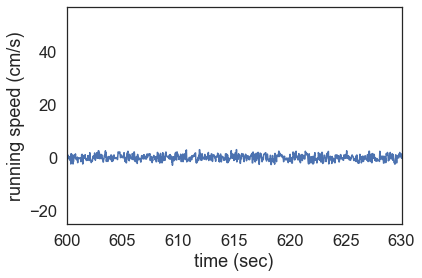

In [30]:
# plot running speed, rewards, and licks
plt.plot(session.running_speed.timestamps, session.running_speed.values)
plt.ylabel('running speed (cm/s)')
plt.xlabel('time (sec)')
plt.xlim(600,630)
plt.plot(session.rewards.index.values, np.repeat(-10, np.shape(session.rewards.index.values)), 'o')
plt.vlines(session.licks,ymin=-10, ymax=-5)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Visual stimuli </h2>
    
<p>The timing of visual stimui can be accessed through the 'stimulus_presentations' table. This includes the timing of omitted stimuli - in other words, the time where the image would have been presented if it were not omitted.  
    
<p>The images shown during the session are included in the 'stimulus_template'. 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 4.1: Get the stimulus table**

<p>Get the `stimulus_presentations` attribute to identify the times of stimulus presentations. How many stimulus flashes were there? 

<p>What other data is included for each stimulus flash in this table? What could it be used for?
    
</div>

In [31]:
# get the stimulus presentations table
session.stimulus_presentations.head()

,image_name,image_index,start_time,stop_time,omitted,change,duration,licks,rewards,running_speed,absolute_flash_number,time_from_last_lick,time_from_last_reward,time_from_last_change,block_index,image_block_repetition,repeat_within_block,image_set
flash_id,,,,,,,,,,,,,,,,,,
0,im065,0,305.64455,305.89475,False,False,0.25020,[],[],-0.000424,0,NaN,NaN,NaN,0,0,0.0,A
1,im065,0,306.39516,306.64538,False,False,0.25022,[],[],-0.277845,1,NaN,NaN,NaN,0,0,1.0,A
2,im065,0,307.14579,307.39597,False,False,0.25018,[],[],-0.169322,2,NaN,NaN,NaN,0,0,2.0,A
3,im065,0,307.89638,308.14660,False,False,0.25022,[],[],0.142601,3,NaN,NaN,NaN,0,0,3.0,A
4,im065,0,308.64735,308.89748,False,False,0.25013,[],[],-0.719413,4,NaN,NaN,NaN,0,0,4.0,A


In [32]:
# how many stimulus presentations were there? 
print('number of stimulus presentations =',len(session.stimulus_presentations))

number of stimulus presentations = 4789


In [33]:
# what are the keys of the stimulus presentations table?
session.stimulus_presentations.keys()

Index(['image_name', 'image_index', 'start_time', 'stop_time', 'omitted',
       'change', 'duration', 'licks', 'rewards', 'running_speed',
       'absolute_flash_number', 'time_from_last_lick', 'time_from_last_reward',
       'time_from_last_change', 'block_index', 'image_block_repetition',
       'repeat_within_block', 'image_set'],
      dtype='object')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 4.2: Plot visual stimulus presentations with behavior events**

<p>1) Copy and paste your code from Task 3.5

<p>2) Plot stimulus presentations using the `start_time` and `stop_time` columns with plt.axvspan(). Set alpha=0.3 & facecolor='gray'.

<p>Hint: Loop through each row of the stimulus table using the pandas method 'iterrows' to plot all stimulus flashes
    
<p>3) Bonus: Plot stimulus presentations corresponding to image changes using the 'changes' column. Set facecolor='blue' to distinguish from non-change flashes. 

</div>

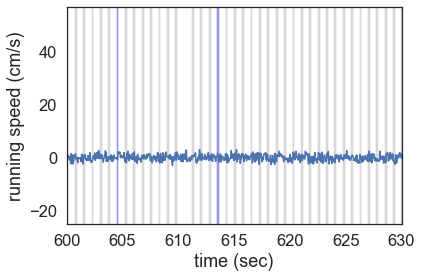

In [34]:
# plot running, rewards, licks and stimuli using axvspan to delineate periods where a stimulus was shown
plt.plot(session.running_speed.timestamps, session.running_speed.values)
plt.ylabel('running speed (cm/s)')
plt.xlabel('time (sec)')
plt.xlim(600,630)
plt.plot(session.rewards.index.values, np.repeat(-10, np.shape(session.rewards.index.values)), 'o')
plt.vlines(session.licks,ymin=-10, ymax=-5)

for index, row in session.stimulus_presentations.iterrows():
    plt.axvspan(row.start_time, row.stop_time,alpha=0.3,facecolor='gray')
    if row.change:
        plt.axvspan(row.start_time, row.stop_time,alpha=0.3,facecolor='blue')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 4.3: Get visual stimulus templates**

<p>Get the `stimulus_templates` from the session object. What is the shape?

<p>The first dimension of `stimulus_templates` corresponds to the `image_index` in `stimulus_presentations`.
    
<p>Plot an image from 'stimulus_templates' using its 'image_index'. Show the name of the image in the title by finding the 'image_name' that corresponds to that 'image_index' in the 'stimulus_presentations' table.
    
</div>

In [35]:
# get the stimulus templates and print the shape
session.stimulus_templates.shape

(8, 918, 1174)

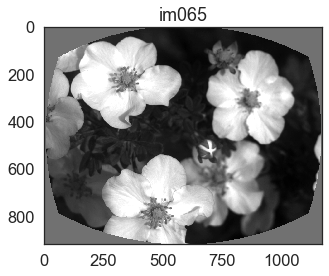

In [38]:
# plot a stimulus using its image index
image_index = 0
plt.imshow(session.stimulus_templates[image_index], cmap='gray')
# show the image name for that image index using the stimulus presentations table and show it in the title
image_index = 0
stimuli = session.stimulus_presentations
image_name = stimuli[stimuli.image_index==image_index].image_name.values[0]
plt.title(image_name);

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Behavior trials data</h2>
    
<p>The `trials` dataframe organizes behavior events (including licking and rewards), stimulus information (what stimulus was shown before and after the scheduled change time) and metadata (such as whether the trial was a 'go' trial or a 'catch' trial) for each behavioral trial. 

<p>This structure is convenient for data exploration and analysis.
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 5.1: Explore the trials table**

<p>1) Get the `trials` attribute of the `session` object. What are the columns of this dataframe? What are the rows?

<p>2) How many go trials were there? How many catch trials? What is the ratio of go to catch trials?

<p>3) What images were shown in this behavior session? Use the pandas 'unique' method to get the unique images from the trials table. 
</div>

In [39]:
# get the trials table 
session.trials.head()

,initial_image_name,change_image_name,change_time,lick_times,response_latency,reward_time,go,catch,hit,miss,false_alarm,correct_reject,aborted,auto_rewarded,reward_volume,start_time,stop_time,trial_length,reward_rate,response_binary
trials_id,,,,,,,,,,,,,,,,,,,,
0,im065,im061,310.89885,[],NaN,NaN,True,False,False,True,False,False,False,False,0,305.592834,315.117318,9.524484,inf,False
1,im061,im077,322.15800,[],NaN,NaN,True,False,False,True,False,False,False,False,0,315.350707,326.376436,11.025729,inf,False
2,im077,im077,329.66416,[],NaN,NaN,False,True,False,False,False,True,False,False,0,326.609901,333.882588,7.272687,inf,False
3,im077,im062,337.17062,[],NaN,NaN,True,False,False,True,False,False,False,False,0,334.116034,341.389143,7.273108,inf,False
4,im062,im062,345.42745,[],NaN,NaN,False,True,False,False,False,True,False,False,0,341.622149,349.645441,8.023291,inf,False


In [40]:
# how many go trials were there? 
print('number of go trials =',len(session.trials[session.trials.go]))

number of go trials = 354


In [41]:
# how many catch trials were there?
print('number of catch trials =',len(session.trials[session.trials.catch]))

number of catch trials = 51


In [42]:
# what images were shown? 
images = session.trials.change_image_name.unique()
print(images)

['im061' 'im077' 'im062' 'im069' 'im066' 'im065' 'im085' 'im063']


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 5.2: Get the hit and false alarm rates for this session**

<p>The hit rate is the fraction of go trials with a lick in the reward window
    
<p>The false alarm rate is the fraction of catch trials with a lick in the reward window

<p>1) Select all the 'go' trials by filtering the dataframe by `go`. Get the fraction of 'go' trials where 'hit' = True. 

<p>2) Repeat for 'catch' trials.

</div>

In [43]:
# compute the hit rate for go trials
go_trials = session.trials[session.trials.go]
print(len(go_trials), 'go trials')
print(np.sum(go_trials.hit), 'hits')
print('hit rate:', round(np.sum(go_trials.hit)/len(go_trials),2))

354 go trials
0 hits
hit rate: 0.0


In [44]:
# compute the false alarm rate for catch trials
catch_trials = session.trials[session.trials.catch]
print(len(catch_trials),'catch trials')
print(np.sum(catch_trials.false_alarm),'false alarms')
print('false alarm rate:',round(np.sum(catch_trials.false_alarm)/len(catch_trials),2))

51 catch trials
0 false alarms
false alarm rate: 0.0


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 5.3: Plot hit rate across images for go trials**

<p>1) Loop through the image names in `session.trials.change_image_name.unique()`

<p>2) Quantify the fraction of 'go' trials with a `hit` for each image

<p>3) Sort the hit rates using np.sort() and plot the sorted hit rate by image
    
<p>4) Get the sorted indices using np.argsort() and apply this ordering to the image names to plot on the x-axis
</div>

In [45]:
# get the hit rate for each image
hit_rates = []
images = session.trials.change_image_name.unique()
for image in images:
    image_change_trials = session.trials[(session.trials.change_image_name == image) & session.trials.go]
    hit_rates.append(np.sum(image_change_trials.hit)/len(image_change_trials))

In [46]:
# sort the hit rates in ascending order and sort the image labels in the same order
hit_rates_sorted = np.sort(hit_rates)
sorted_order = np.argsort(hit_rates)
images_sorted = images[sorted_order]

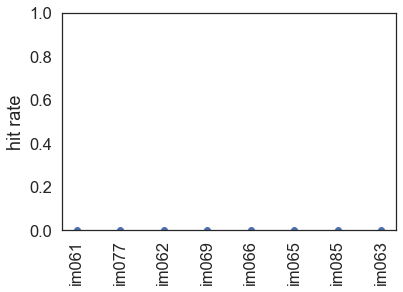

In [47]:
# plot hit rate by image with image names on the x-axis
fig, ax = plt.subplots()
plt.plot(hit_rates_sorted, 'o')
ax.set_xticks(np.arange(0,len(images_sorted),1));
ax.set_xticklabels(images_sorted, rotation=90);
ax.set_ylabel('hit rate');
ax.set_ylim(0,1);

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 5.4: Plot a lick raster**

<p>Provide the `trials` dataframe to the function below to plot a lick raster.

<p>Is the mouse performing the task consistently across the whole session?
</div>

In [48]:
def make_lick_raster(trials):
    trials = trials[trials.aborted==False]
    trials = trials.reset_index()
    fig,ax = plt.subplots(figsize=(5,10))
    for trial_index, trial_data in trials.iterrows(): 
        # get times relative to change time
        lick_times = [(t - trial_data.change_time) for t in trial_data.lick_times]
        reward_time = [(t - trial_data.change_time) for t in [trial_data.reward_time]]
        # plot reward times
        if len(reward_time) > 0:
            ax.plot(reward_time[0], trial_index + 0.5, '.', color='b', label='reward', markersize=6)
        # plot lick times
        ax.vlines(lick_times, trial_index, trial_index + 1, color='k', linewidth=1)
        # put a line at the change time
        ax.vlines(0, trial_index, trial_index + 1, color=[.5, .5, .5], linewidth=1)
    # gray bar for response window
    ax.axvspan(0.15, 0.75, facecolor='gray', alpha=.3, edgecolor='none')
    ax.grid(False)
    ax.set_ylim(0, len(trials))
    ax.set_xlim([-1, 4])
    ax.set_ylabel('trials')
    ax.set_xlabel('time (sec)')
    ax.set_title('lick raster')
    plt.gca().invert_yaxis()

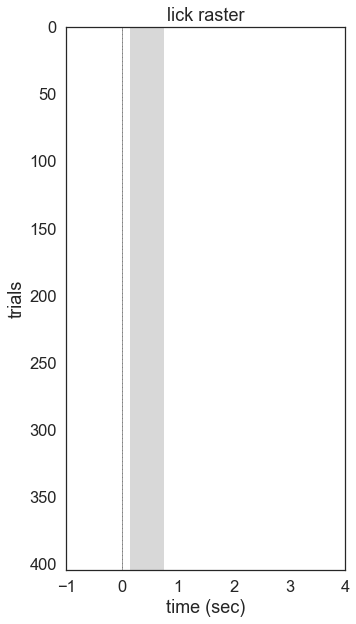

In [49]:
# plot the lick raster for this session using the provided function
make_lick_raster(session.trials)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>The Trial Response and Flash Response dataframes organize cell responses by behavior trials and stimulus flashes </h2>
    
<p> These two dataframes do the work of temporal alignment for you to create a convenient data structure for analysis. 
  
<p> The `trial_response_df` extracts cell responses for each behavioral trial in a [-4,8] second window around the change time.
    
<p> The `flash_response_df` extracts cell responses for each stimulus presentation in a [-0.5, 0.75] second window around each flash. 
    
<p> Both dataframes take the mean response for each cell in a 500ms window after the change time for trials, or after the stimulus onset time for stimulus presentations.
    
<p> These dataframes also include a p_value comparing the response for each cell on each trial to a shuffled distribution from the spontaneous activity epochs. 

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 6.1:** Load and explore the Trial Response Dataframe. 

<p>1) Get the `trial_response_df` attribute of the session object. What are the columns? What are the rows? What is different than the `trials` table? 
    
<p>The `dff_trace` column contains a portion of each cell's dF/F trace from 4 seconds before the `change_time` to 8 seconds after the 'change_time' for each trial. There are also `dff_trace_timestamps` for the same window. 

<p> For each trial, the `mean_response` of each cell is computed for a 500ms window after the `change_time`.

<p>2) Assign `trial_response_df` to a variable named `tr` for convenient use in later exercises.
    
</div>

In [50]:
# get the trial response dataframe and assign it to 'tr'
tr = session.trial_response_df

In [51]:
# what is in the trial response dataframe?
tr.head()

,trial_id,change_image_name,dff_trace,dff_trace_timestamps,mean_response,baseline_response,initial_image_name,change_time,lick_times,response_latency,...,aborted,auto_rewarded,reward_volume,start_time,stop_time,trial_length,reward_rate,response_binary,p_value,pref_stim
cell_specimen_id,,,,,,,,,,,,,,,,,,,,,
915115528,0,im061,"[-0.027956282453658523, -0.10043380499108052, ...","[306.89379, 306.9261, 306.95842, 306.99073, 30...",-0.005323,-0.014685,im065,310.89885,[],NaN,...,False,False,0,305.592834,315.117318,9.524484,inf,0,0.511982,False
915115528,1,im077,"[-0.028761492572436535, -0.012973715799265186,...","[318.17203, 318.20435, 318.23666, 318.26898, 3...",0.032734,-0.005370,im061,322.15800,[],NaN,...,False,False,0,315.350707,326.376436,11.025729,inf,0,0.065125,True
915115528,2,im077,"[0.11527301311504866, -0.04719088329624451, 0....","[325.66932, 325.70164, 325.73395, 325.76627, 3...",-0.011972,-0.025758,im077,329.66416,[],NaN,...,False,False,0,326.609901,333.882588,7.272687,inf,0,0.349320,True
915115528,3,im062,"[-0.13579039478792435, 0.012083089856508184, -...","[333.16662, 333.19893, 333.23125, 333.26356, 3...",0.034912,0.061277,im077,337.17062,[],NaN,...,False,False,0,334.116034,341.389143,7.273108,inf,0,0.231734,False
915115528,4,im062,"[-0.007059301896353609, 0.01781494471308024, -...","[341.4395, 341.47182, 341.50413, 341.53645, 34...",0.006197,-0.005493,im062,345.42745,[],NaN,...,False,False,0,341.622149,349.645441,8.023291,inf,0,0.396821,False


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 6.2:** Plot the population average trace for go trials. 

<p>Select go trials from the 'trial_response_df', take the mean across all cells, all trials, and plot it
    
</div>

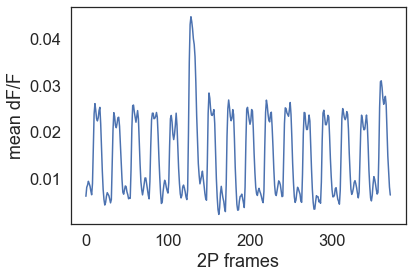

In [52]:
# plot the mean trace across all cells for go trials
fig, ax = plt.subplots()

traces = tr[tr.go==True].dff_trace.values
mean_trace = np.mean(traces, axis=0)
ax.plot(mean_trace)
ax.set_xlabel('2P frames');
ax.set_ylabel('mean dF/F');

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 6.3: Plot the population response across cells for one change trial**

<p>1) Select one 'trial_id' where 'go' = True and filter the trial_response_df to get the data for just that trial. How many rows are in this subset of data? Is it the same length as the number of unique cells?

<p>2) Get the 'mean_response' for all cells,  sort in order of response magnitude and plot it. 
    
</div>

In [53]:
# get data for all cells for a single go trial
go_trials = tr[tr.go==True].trial_id.values
some_go_trial = go_trials[10]

trial_data = tr[tr.trial_id==some_go_trial]
trial_data.head()

,trial_id,change_image_name,dff_trace,dff_trace_timestamps,mean_response,baseline_response,initial_image_name,change_time,lick_times,response_latency,...,aborted,auto_rewarded,reward_volume,start_time,stop_time,trial_length,reward_rate,response_binary,p_value,pref_stim
cell_specimen_id,,,,,,,,,,,,,,,,,,,,,
915115528,12,im085,"[-0.028072856741893026, -0.024975185336307687,...","[408.23678, 408.2691, 408.30141, 408.33373, 40...",0.018024,-0.023186,im077,412.23152,[],NaN,...,False,False,0,409.177481,416.433241,7.25576,0.0,0,0.007032,False
915116952,12,im085,"[0.07962990241702506, -0.10189634952804753, -0...","[408.23678, 408.2691, 408.30141, 408.33373, 40...",0.047965,-0.007550,im077,412.23152,[],NaN,...,False,False,0,409.177481,416.433241,7.25576,0.0,0,0.012107,False
915113524,12,im085,"[0.044582354492514714, -0.00337716643045957, 0...","[408.23678, 408.2691, 408.30141, 408.33373, 40...",0.042980,0.000090,im077,412.23152,[],NaN,...,False,False,0,409.177481,416.433241,7.25576,0.0,0,0.039223,False
915104047,12,im085,"[-0.038649817469335, 0.007011896848113542, -0....","[408.23678, 408.2691, 408.30141, 408.33373, 40...",0.009527,-0.029604,im077,412.23152,[],NaN,...,False,False,0,409.177481,416.433241,7.25576,0.0,0,0.035368,False
915113226,12,im085,"[-0.07752627917568225, -0.0518836523478143, 0....","[408.23678, 408.2691, 408.30141, 408.33373, 40...",0.013860,-0.023543,im077,412.23152,[],NaN,...,False,False,0,409.177481,416.433241,7.25576,0.0,0,0.005674,False


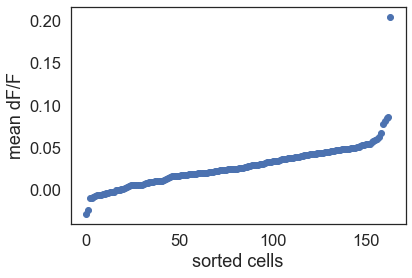

In [54]:
# plot the mean response across cells for this trial, with cells on x-axis and mean dF/F on y-axis
plt.plot(np.sort(trial_data.mean_response.values), 'o')
plt.ylabel('mean dF/F');
plt.xlabel('sorted cells');

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 6.4: Explore the flash response dataframe**

<p>What is in the `flash_response_df` attribute of the session object? What are the columns? What are the rows?  How is it different from the `stimulus_presentations` table?

<p>The`flash_response_df` contains the cell responses for individual stimulus presentations, aka flashes. It contains the `mean_response` of every cell in a 500ms window after every stimulus onset, for all stimulus presentations during the behavior session.  

</div>

In [55]:
# get the flash response dataframe and assign it to 'fr'
fr = session.flash_response_df

In [56]:
# whats in the flash response dataframe?
fr.head()

,flash_id,dff_trace,dff_trace_timestamps,mean_response,baseline_response,p_value,pref_stim,image_name,image_index,start_time,...,rewards,running_speed,absolute_flash_number,time_from_last_lick,time_from_last_reward,time_from_last_change,block_index,image_block_repetition,repeat_within_block,image_set
cell_specimen_id,,,,,,,,,,,,,,,,,,,,,
915103117,0,"[0.06333417566149534, 0.03981458902415219, 0.1...","[305.18105, 305.21336, 305.24568, 305.27799, 3...",0.024260,0.024154,0.1906,False,im065,0,305.64455,...,[],-0.000424,0,NaN,NaN,NaN,0,0,0.0,A
915103117,1,"[0.11492372862503913, 0.07728290504889686, 0.0...","[305.92431, 305.95663, 305.98894, 306.02126, 3...",-0.020871,-0.001415,0.9294,False,im065,0,306.39516,...,[],-0.277845,1,NaN,NaN,NaN,0,0,1.0,A
915103117,2,"[0.01659793188355077, -0.017878390771586865, 0...","[306.66758, 306.69989, 306.73221, 306.76452, 3...",-0.040246,-0.039781,0.9898,False,im065,0,307.14579,...,[],-0.169322,2,NaN,NaN,NaN,0,0,2.0,A
915103117,3,"[-0.0452463848167309, -0.01657040181581845, -0...","[307.44316, 307.47547, 307.50779, 307.5401, 30...",-0.055758,-0.069766,0.9999,False,im065,0,307.89638,...,[],0.142601,3,NaN,NaN,NaN,0,0,3.0,A
915103117,4,"[-0.09159589797997744, -0.16559014442141792, -...","[308.18642, 308.21874, 308.25105, 308.28337, 3...",0.033146,-0.044259,0.1038,False,im065,0,308.64735,...,[],-0.719413,4,NaN,NaN,NaN,0,0,4.0,A


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 6.5: Plot the mean response to each image across all flashes**

<p>1) Select one image and plot the mean response across all cells using the 'dff_trace' column. Put the 'image_name' in the title. 
    
<p>2) Plot the mean response to all images on the same figure. 

</div>

Text(0, 0.5, 'dF/F')

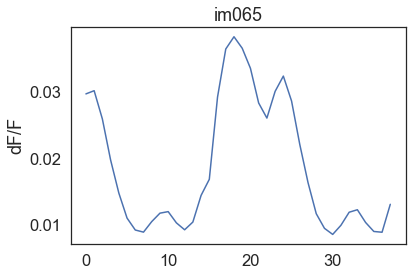

In [57]:
# plot the mean trace across all cells for one image
image_names = fr.image_name.unique()
image_name = image_names[0]
traces = fr[fr.image_name==image_name].dff_trace
mean_image_trace = np.mean(traces, axis=0)
plt.plot(mean_image_trace);
plt.title(image_name);
plt.ylabel('dF/F')

Text(0, 0.5, 'dF/F')

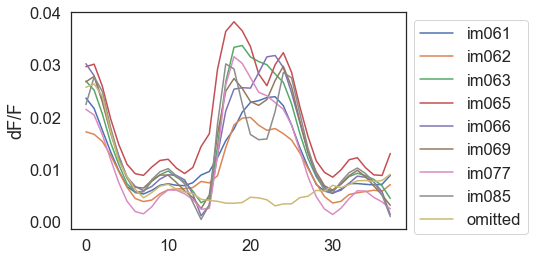

In [58]:
# plot the mean trace across cells separately for each image
image_names = np.sort(fr.image_name.unique())

fig, ax = plt.subplots()
for image_name in image_names: 
    traces = fr[fr.image_name==image_name].dff_trace
    mean_image_trace = np.mean(traces, axis=0)
    ax.plot(mean_image_trace, label=image_name);
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel('dF/F')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 6.6: Plot one cell's response to each image across all flashes**
    
<p>Create the same plot for a single cell rather than the whole population. 
    
<p>What does it look like for different cells?
    
</div>

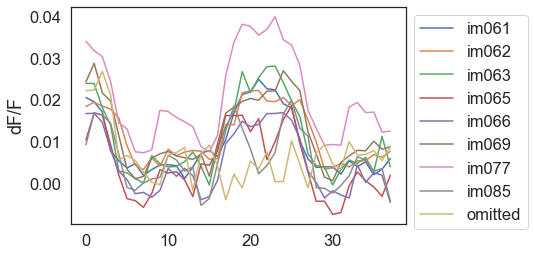

In [59]:
# plot the mean trace across images for one cell
cell_specimen_ids = fr.index.values
cell_specimen_id = cell_specimen_ids[4]
cell_data = fr.loc[cell_specimen_id]

fig, ax = plt.subplots()
image_names = np.sort(fr.image_name.unique())
for image_name in image_names: # loop through images
    traces = cell_data[cell_data.image_name==image_name].dff_trace # get traces for one image
    mean_image_trace = np.mean(traces, axis=0)
    ax.plot(mean_image_trace, label=image_name);
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel('dF/F');